In [1]:
import numpy as np
import idi.simulation as sim
!hostname

psanagpu106


**Settings**

In [2]:
inputfile='out.npz'
Nphotons=int(1e5)
Nimg=np.inf # np.inf: use all

**Load Simulation Data**

In [3]:
f=np.load(inputfile)
f['settings']

array([{'Natoms': 1000000, 'Ndet': 1024, 'detz': 4.1, 'Nimg': 200, 'a': 3.6, 'pixelsize': 75, 'E': 8040, 'rndphase': True, 'rotangles': array([0.17453293, 0.17453293, 0.17453293])},
       list(['gridfcc'])], dtype=object)

In [4]:
probs=f['result']
z=f['settings'][0]['detz']*0.01/f['settings'][0]['pixelsize']/1e-6
_Nimg=min(Nimg,probs.shape[0])

**Image Degradation**

In [5]:
def mesh(*args):
    ranges=[np.arange(d) for d in args]
    return np.meshgrid(*ranges)

#add mask
mask=np.ones_like(probs[0,...])
mask[500:-500,:]=0
mask[:,475:-475]=0
probs=probs*mask

#add filter
x,y=mesh(probs.shape[1],probs.shape[2])
c=(np.array(probs.shape)//2)[1:]
filter=(1-(0.1*np.abs(x-c[0])/c[0]))*(1-(0.05*np.abs(y-c[1])/c[1]))**2
filter+=np.random.randn(*filter.shape)/20
probs=probs*filter

In [6]:
# simulate random photons
images=np.array(sim.common.randomphotons(probs,Nphotons))

In [7]:
#add noise
noise=np.array(sim.common.randomphotons(np.ones_like(images),int(Nphotons/100))).astype(float)
noise+=np.random.rand(*images.shape)/5
images=images+noise

#add decentered padding
images=np.pad(images,((0,0),(15,8),(5,12)),'constant')

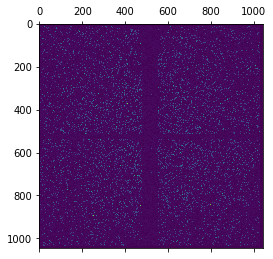

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(images[0,...])

**Reconstruction**

In [9]:
import idi.reconstruction as recon

In [10]:
mean=np.mean(images,axis=0)

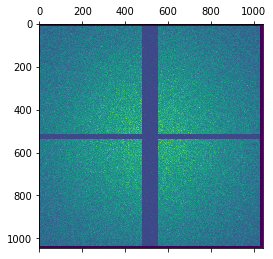

In [11]:
plt.matshow(mean)

In [12]:
t=recon.ft.corr(images[:_Nimg,...],z,verbose=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [13]:
#doing a copy just to save you from redoing the correlations
res=t.copy()

In [14]:
import scipy.signal as ss
#median filter the mean to decrease influence of noise.
#mean=ss.medfilt2d(mean,3)
norm=recon.ft.corr(mean,z)

In [15]:
def unwrap(img):
    return np.roll(img[...,:-2],shift=(img.shape[1]//2,(img.shape[2]-2)//2),axis=(1,2))

In [16]:
# process result from ft reconstruction (inplace)
np.divide(res,norm,out=res)
res[norm<1e10]=0
np.divide(res,_Nimg,out=res)
np.subtract(res,1,out=res)
res=unwrap(res)

/reg/neh/home/zimmf/.conda/envs/local3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/reg/neh/home/zimmf/.conda/envs/local3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


**Plot**

In [17]:
#resample with maximum filter to make small peaks easier to spot
import idi.util
res=idi.util.bin(res[:-1,...],np.array(res.shape)//2,'max')

In [25]:
#plotlimits
vmax=np.nanpercentile(res[res>0],99.9)
vmin=np.nanpercentile(res[res>0],30)

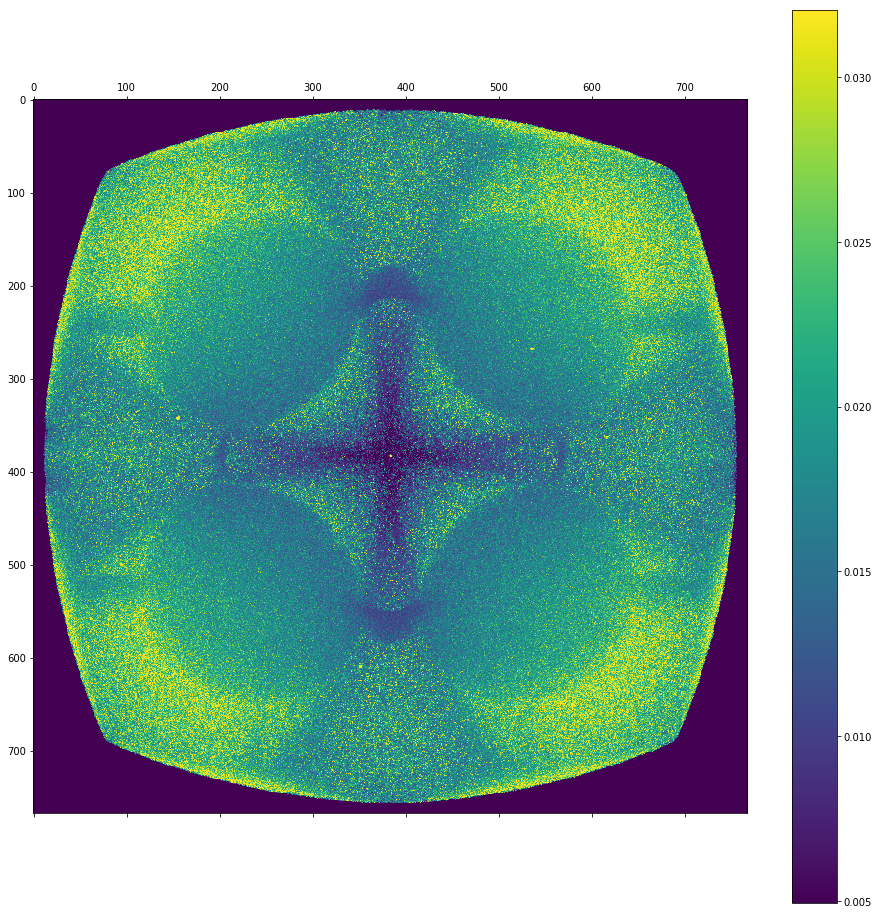

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (30,30)
plt.matshow(np.nanmax(res[:80,...],axis=0),vmin=vmin,vmax=vmax)
#plt.savefig('out.png',dpi=1200)
plt.colorbar()